In [ ]:

# Cell 1: Install necessary packages
!pip install tensorflow keras matplotlib scikit-learn scikit-image opencv-python

In [ ]:
# Cell 2: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from skimage.io import imread
from skimage.transform import resize
from google.colab import drive

In [ ]:
# Cell 3: Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Update these paths to match your Google Drive structure
BASE_PATH = '/content/drive/MyDrive/BCDR_dataset'  # Change this according to your drive structure
IMAGE_PATH = os.path.join(BASE_PATH, 'BCDR-BCDR-SELECTED-IMGS')
MASK_PATH = os.path.join(BASE_PATH, 'BCDR-BCDR-SELECTED-MASKS')

In [ ]:
# Cell 5: Parameters for the model
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 50
SEED = 42

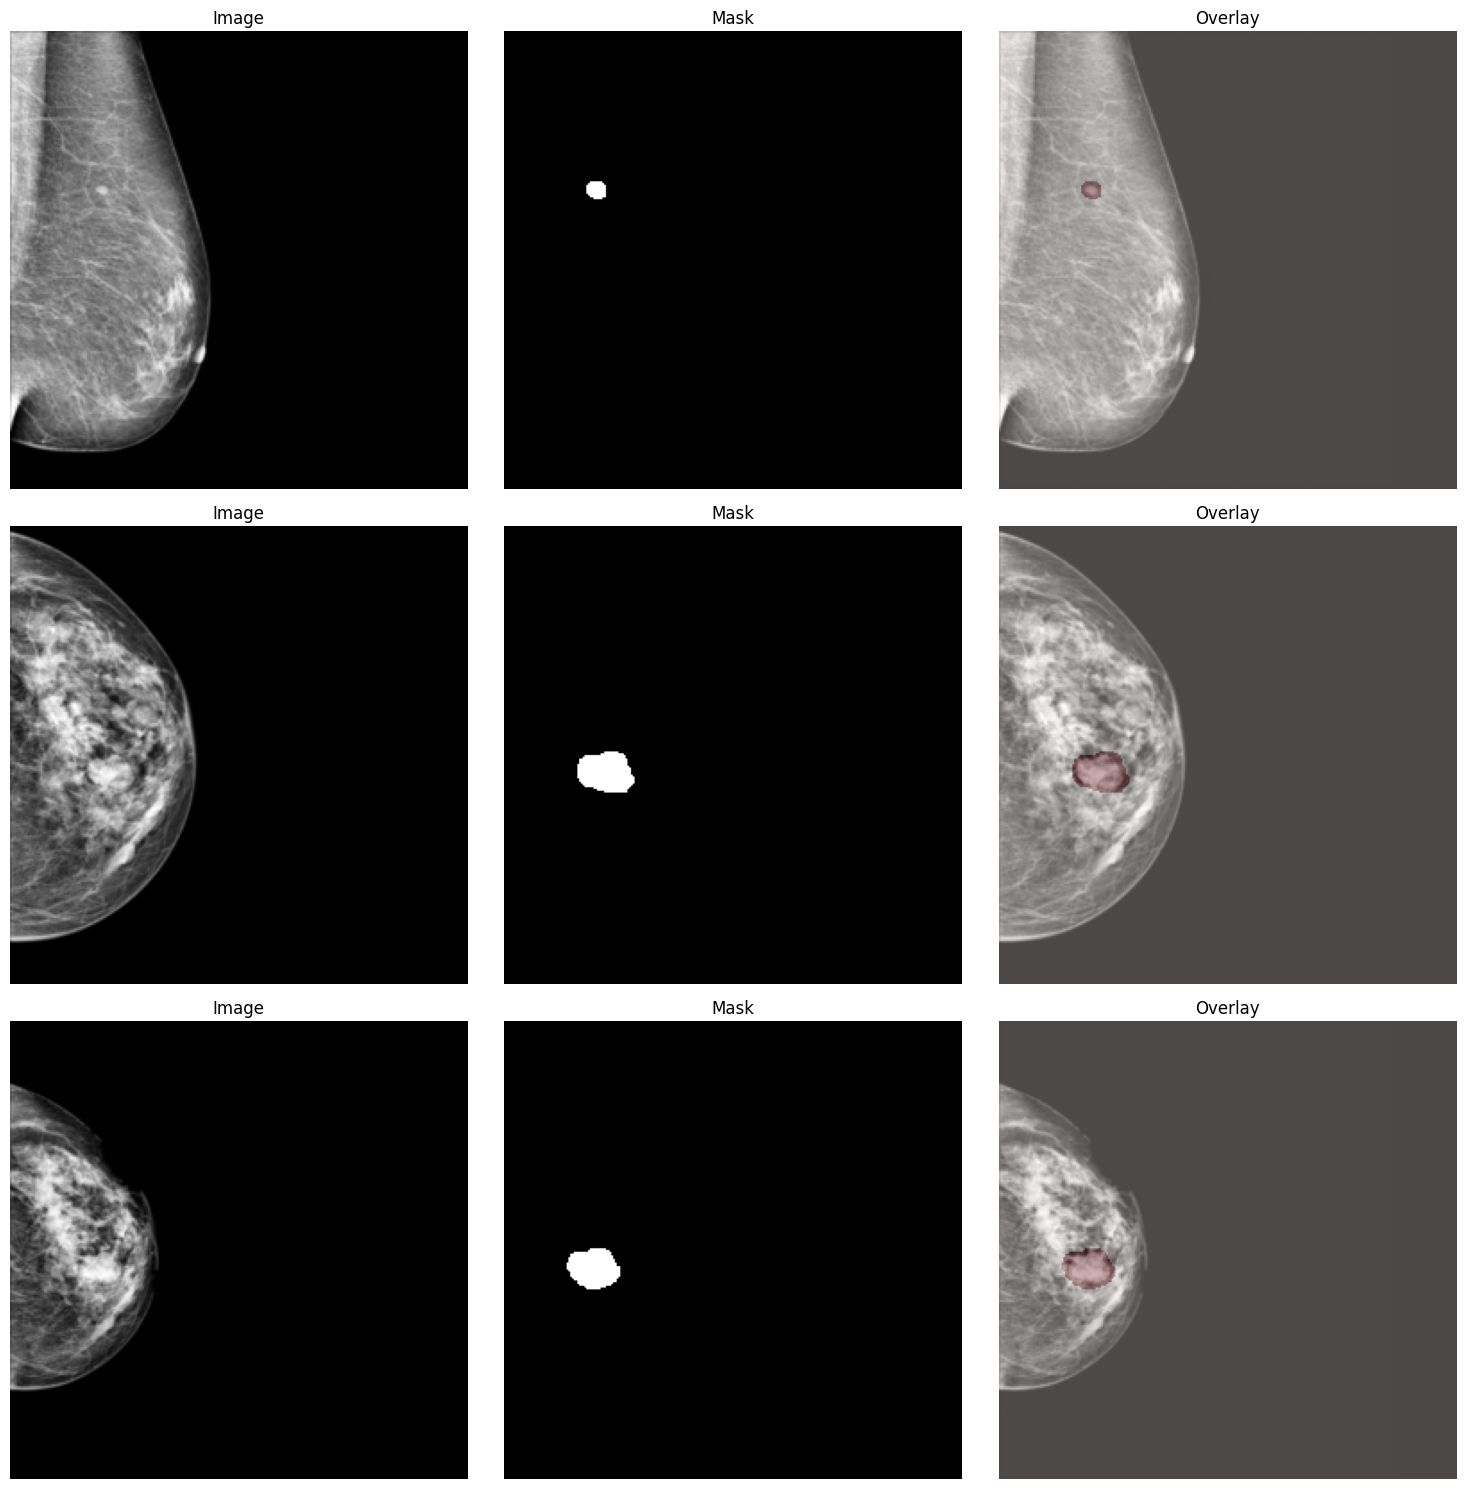

In [ ]:
# Cell 6 (Updated): Data loading and preprocessing functions
def load_data(image_path, mask_path):
    """Load all images and masks, then return lists of image paths and mask paths"""
    images = sorted(glob(os.path.join(image_path, "*.png")))
    masks = sorted(glob(os.path.join(mask_path, "*.png")))

    print(f"Found {len(images)} images and {len(masks)} masks")

    # Verify that image and mask names match
    for img_path, mask_path in zip(images[:5], masks[:5]):
        img_name = os.path.basename(img_path).replace("___PRE.png", "")
        mask_name = os.path.basename(mask_path).replace("_MASK___PRE.png", "")
        print(f"Image: {img_name}, Mask: {mask_name}")

    return images, masks

def preprocess_image(image_path, mask_path):
    """Read and preprocess an image and its mask"""
    # Read image and mask
    image = imread(image_path, as_gray=True)
    mask = imread(mask_path, as_gray=True)

    # Resize
    image = resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)

    # Normalize image to [0, 1]
    image = image / 255.0

    # Threshold the mask to binary (0 or 1)
    mask = (mask > 0).astype(np.float32)

    # Add channel dimension
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

# FIXED FUNCTION - Removed decode() calls
def create_dataset(image_paths, mask_paths):
    """Create a TensorFlow dataset from lists of image and mask paths"""
    images = []
    masks = []

    # Preprocess all images and masks
    for img_path, mask_path in zip(image_paths, mask_paths):
        img, mask = preprocess_image(img_path, mask_path)
        images.append(img)
        masks.append(mask)

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    # Create TensorFlow dataset directly from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    return dataset

# Alternative approach if the above uses too much memory:
def create_dataset_v2(image_paths, mask_paths):
    """Create a TensorFlow dataset that loads images on-the-fly"""

    def load_and_preprocess(img_path, mask_path):
        # Convert tensor to string
        if hasattr(img_path, 'numpy'):
            img_path = img_path.numpy().decode('utf-8')
            mask_path = mask_path.numpy().decode('utf-8')

        # Process the image and mask
        img, mask = preprocess_image(img_path, mask_path)
        return img, mask

    # Create dataset of paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Map to preprocess function that handles tensors correctly
    dataset = dataset.map(
        lambda img_path, mask_path: tf.py_function(
            func=load_and_preprocess,
            inp=[img_path, mask_path],
            Tout=[tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return dataset

# Cell 8 (Updated): Create datasets
# Choose one of the dataset creation methods:
# Option 1: Preload all data into memory
train_dataset = create_dataset(train_img_paths, train_mask_paths)
val_dataset = create_dataset(val_img_paths, val_mask_paths)

# OR Option 2: Load data on-the-fly (better for large datasets)
# train_dataset = create_dataset_v2(train_img_paths, train_mask_paths)
# val_dataset = create_dataset_v2(val_img_paths, val_mask_paths)

# Configure datasets for performance
train_dataset = train_dataset.shuffle(buffer_size=len(train_img_paths), seed=SEED)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Cell 9 (Updated): Visualize a few examples
def visualize_samples(dataset, num_samples=3):
    """Visualize sample images and masks from the dataset"""
    plt.figure(figsize=(15, 5*num_samples))

    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Get the first image and mask from the batch
        img = images[0].numpy().squeeze()
        msk = masks[0].numpy().squeeze()

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img, cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(msk, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(msk, alpha=0.3, cmap='Reds')
        plt.title('Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

try:
    visualize_samples(train_dataset)
except Exception as e:
    print(f"Error visualizing samples: {e}")
    # If visualization fails, print a sample shape
    for images, masks in train_dataset.take(1):
        print(f"Image batch shape: {images.shape}")
        print(f"Mask batch shape: {masks.shape}")

In [ ]:
# Cell 10: Define U-Net model
def build_unet_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)):
    """Build a U-Net model"""
    inputs = Input(input_shape)

    # Encoder (Downsampling)
    # Block 1
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (Upsampling)
    # Block 6
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    # Block 7
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    # Block 8
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    # Block 9
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Cell 11: Create and compile the model
def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Calculate Dice coefficient"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Calculate Dice loss"""
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined binary crossentropy and Dice loss"""
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

# Initialize and compile the model
unet_model = build_unet_model()
unet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coefficient, 'binary_accuracy']
)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 12: Define callbacks for training
callbacks = [
    ModelCheckpoint(
        filepath='unet_mammography_best_model.h5',
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )
]

In [ ]:
# Cell 13: Train the model
history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9922 - dice_coefficient: 0.0145 - loss: 1.6673   
Epoch 1: val_dice_coefficient improved from -inf to 0.01238, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - binary_accuracy: 0.9921 - dice_coefficient: 0.0147 - loss: 1.6664 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0124 - val_loss: 1.6179 - learning_rate: 1.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - binary_accuracy: 0.9915 - dice_coefficient: 0.0072 - loss: 1.4859
Epoch 2: val_dice_coefficient did not improve from 0.01238
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - binary_accuracy: 0.9914 - dice_coefficient: 0.0068 - loss: 1.4783 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 8.1120e-04 - val_loss: 1.2801 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - binary_accuracy: 0.9920 - dice_coefficient: 0.0028 - loss: 1.2553
Epoch 3: val_dice_coefficient did not improve from 0.01238
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - binary_accuracy: 0.9919 - dice_coefficient: 0.0028 - loss: 1.2544 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 9.3409e-04 - val_loss: 1.1091 - learning_rate: 1.00

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step - binary_accuracy: 0.9907 - dice_coefficient: 0.0036 - loss: 1.1538 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0149 - val_loss: 1.1187 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - binary_accuracy: 0.9918 - dice_coefficient: 0.0213 - loss: 1.0483
Epoch 5: val_dice_coefficient improved from 0.01488 to 0.03027, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 704ms/step - binary_accuracy: 0.9917 - dice_coefficient: 0.0213 - loss: 1.0474 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0303 - val_loss: 1.0256 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - binary_accuracy: 0.9923 - dice_coefficient: 0.0342 - loss: 1.0207
Epoch 6: val_dice_coefficient improved from 0.03027 to 0.04330, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step - binary_accuracy: 0.9922 - dice_coefficient: 0.0367 - loss: 1.0196 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0433 - val_loss: 1.0229 - learning_rate: 1.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - binary_accuracy: 0.9897 - dice_coefficient: 0.0587 - loss: 1.0035
Epoch 7: val_dice_coefficient improved from 0.04330 to 0.04478, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 696ms/step - binary_accuracy: 0.9899 - dice_coefficient: 0.0571 - loss: 1.0040 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0448 - val_loss: 1.0114 - learning_rate: 1.0000e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - binary_accuracy: 0.9910 - dice_coefficient: 0.0619 - loss: 0.9911
Epoch 8: val_dice_coefficient improved from 0.04478 to 0.04724, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - binary_accuracy: 0.9911 - dice_coefficient: 0.0612 - loss: 0.9912 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0472 - val_loss: 0.9958 - learning_rate: 1.0000e-04
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - binary_accuracy: 0.9917 - dice_coefficient: 0.0601 - loss: 0.9855
Epoch 9: val_dice_coefficient improved from 0.04724 to 0.04862, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 798ms/step - binary_accuracy: 0.9917 - dice_coefficient: 0.0606 - loss: 0.9847 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0486 - val_loss: 0.9921 - learning_rate: 1.0000e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - binary_accuracy: 0.9912 - dice_coefficient: 0.0780 - loss: 0.9653
Epoch 10: val_dice_coefficient improved from 0.04862 to 0.06258, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - binary_accuracy: 0.9912 - dice_coefficient: 0.0776 - loss: 0.9654 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0626 - val_loss: 0.9886 - learning_rate: 1.0000e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - binary_accuracy: 0.9927 - dice_coefficient: 0.0683 - loss: 0.9822
Epoch 11: val_dice_coefficient improved from 0.06258 to 0.07597, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 674ms/step - binary_accuracy: 0.9926 - dice_coefficient: 0.0729 - loss: 0.9815 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0760 - val_loss: 0.9723 - learning_rate: 1.0000e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - binary_accuracy: 0.9905 - dice_coefficient: 0.1251 - loss: 0.9254
Epoch 12: val_dice_coefficient did not improve from 0.07597
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - binary_accuracy: 0.9906 - dice_coefficient: 0.1216 - loss: 0.9292 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0655 - val_loss: 0.9901 - learning_rate: 1.0000e-04
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - binary_accuracy: 0.9924 - dice_coefficient: 0.1024 - loss: 0.9476
Epoch 13: val_dice_coefficient did not improve from 0.07597
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - binary_accuracy: 0.9923 - dice_coefficient: 0.1024 - loss: 0.9468 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0718 - val_loss: 0.9825 - learning_rate: 1.0000e

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step - binary_accuracy: 0.9918 - dice_coefficient: 0.1195 - loss: 0.9427 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0785 - val_loss: 0.9759 - learning_rate: 1.0000e-04
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - binary_accuracy: 0.9886 - dice_coefficient: 0.1772 - loss: 0.8665
Epoch 16: val_dice_coefficient improved from 0.07850 to 0.08339, saving model to unet_mammography_best_model.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - binary_accuracy: 0.9889 - dice_coefficient: 0.1708 - loss: 0.8718 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0834 - val_loss: 0.9842 - learning_rate: 1.0000e-04
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - binary_accuracy: 0.9895 - dice_coefficient: 0.1707 - loss: 0.8776
Epoch 17: val_dice_coefficient improved from 0.08339 to 0.08745, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 706ms/step - binary_accuracy: 0.9897 - dice_coefficient: 0.1674 - loss: 0.8799 - val_binary_accuracy: 0.9923 - val_dice_coefficient: 0.0874 - val_loss: 0.9719 - learning_rate: 5.0000e-05
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - binary_accuracy: 0.9922 - dice_coefficient: 0.1644 - loss: 0.8699
Epoch 18: val_dice_coefficient improved from 0.08745 to 0.11107, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 659ms/step - binary_accuracy: 0.9922 - dice_coefficient: 0.1636 - loss: 0.8693 - val_binary_accuracy: 0.9922 - val_dice_coefficient: 0.1111 - val_loss: 0.9304 - learning_rate: 5.0000e-05
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - binary_accuracy: 0.9902 - dice_coefficient: 0.2244 - loss: 0.8117
Epoch 19: val_dice_coefficient improved from 0.11107 to 0.12618, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 675ms/step - binary_accuracy: 0.9902 - dice_coefficient: 0.2199 - loss: 0.8159 - val_binary_accuracy: 0.9899 - val_dice_coefficient: 0.1262 - val_loss: 0.9152 - learning_rate: 5.0000e-05
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - binary_accuracy: 0.9900 - dice_coefficient: 0.2492 - loss: 0.7885
Epoch 20: val_dice_coefficient did not improve from 0.12618
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 504ms/step - binary_accuracy: 0.9901 - dice_coefficient: 0.2423 - loss: 0.7939 - val_binary_accuracy: 0.9710 - val_dice_coefficient: 0.1020 - val_loss: 0.9565 - learning_rate: 5.0000e-05
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - binary_accuracy: 0.9784 - dice_coefficient: 0.1940 - loss: 0.8495
Epoch 21: val_dice_coefficient improved from 0.12618 to 0.12817, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 640ms/step - binary_accuracy: 0.9789 - dice_coefficient: 0.1921 - loss: 0.8490 - val_binary_accuracy: 0.9921 - val_dice_coefficient: 0.1282 - val_loss: 0.9208 - learning_rate: 5.0000e-05
Epoch 22/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - binary_accuracy: 0.9914 - dice_coefficient: 0.2695 - loss: 0.7688
Epoch 22: val_dice_coefficient improved from 0.12817 to 0.16218, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 697ms/step - binary_accuracy: 0.9914 - dice_coefficient: 0.2673 - loss: 0.7685 - val_binary_accuracy: 0.9900 - val_dice_coefficient: 0.1622 - val_loss: 0.8767 - learning_rate: 5.0000e-05
Epoch 23/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - binary_accuracy: 0.9922 - dice_coefficient: 0.2322 - loss: 0.8013
Epoch 23: val_dice_coefficient did not improve from 0.16218
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - binary_accuracy: 0.9920 - dice_coefficient: 0.2313 - loss: 0.8022 - val_binary_accuracy: 0.9460 - val_dice_coefficient: 0.1175 - val_loss: 0.9519 - learning_rate: 5.0000e-05
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - binary_accuracy: 0.9655 - dice_coefficient: 0.1949 - loss: 0.8559
Epoch 24: val_dice_coefficient did not improve from 0.16218
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - binary_accuracy: 0.9668 - dice_coefficient: 0.1971 - loss: 0.8509 - val_binary_accuracy: 0.9924 - val_dice_coefficient: 0.0859 - val_loss: 0.9740 - learning_rate: 5.0000e-

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step - binary_accuracy: 0.9896 - dice_coefficient: 0.2156 - loss: 0.8237 - val_binary_accuracy: 0.9889 - val_dice_coefficient: 0.2566 - val_loss: 0.7717 - learning_rate: 5.0000e-05
Epoch 26/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - binary_accuracy: 0.9907 - dice_coefficient: 0.2684 - loss: 0.7635
Epoch 26: val_dice_coefficient did not improve from 0.25657
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step - binary_accuracy: 0.9906 - dice_coefficient: 0.2645 - loss: 0.7668 - val_binary_accuracy: 0.9787 - val_dice_coefficient: 0.1210 - val_loss: 0.9372 - learning_rate: 5.0000e-05
Epoch 27/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - binary_accuracy: 0.9860 - dice_coefficient: 0.2076 - loss: 0.8436
Epoch 27: val_dice_coefficient did not improve from 0.25657
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - binary_accuracy: 0.9861 - dice_coefficient: 0.2113 - loss: 0.8423 - val_binary_accuracy: 0.9926 - val_dice_coefficient: 0.2146 - val_loss: 0.8243 - learning_rate: 5.0000e-

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 713ms/step - binary_accuracy: 0.9907 - dice_coefficient: 0.2985 - loss: 0.7329 - val_binary_accuracy: 0.9902 - val_dice_coefficient: 0.2621 - val_loss: 0.7686 - learning_rate: 5.0000e-05
Epoch 29/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - binary_accuracy: 0.9868 - dice_coefficient: 0.3134 - loss: 0.7197
Epoch 29: val_dice_coefficient improved from 0.26212 to 0.26910, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 966ms/step - binary_accuracy: 0.9869 - dice_coefficient: 0.3210 - loss: 0.7150 - val_binary_accuracy: 0.9920 - val_dice_coefficient: 0.2691 - val_loss: 0.7634 - learning_rate: 5.0000e-05
Epoch 30/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - binary_accuracy: 0.9915 - dice_coefficient: 0.3594 - loss: 0.6754
Epoch 30: val_dice_coefficient improved from 0.26910 to 0.29015, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 959ms/step - binary_accuracy: 0.9914 - dice_coefficient: 0.3610 - loss: 0.6764 - val_binary_accuracy: 0.9898 - val_dice_coefficient: 0.2902 - val_loss: 0.7479 - learning_rate: 5.0000e-05
Epoch 31/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - binary_accuracy: 0.9922 - dice_coefficient: 0.4462 - loss: 0.5744
Epoch 31: val_dice_coefficient improved from 0.29015 to 0.32622, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 682ms/step - binary_accuracy: 0.9921 - dice_coefficient: 0.4392 - loss: 0.5771 - val_binary_accuracy: 0.9933 - val_dice_coefficient: 0.3262 - val_loss: 0.7116 - learning_rate: 5.0000e-05
Epoch 32/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - binary_accuracy: 0.9919 - dice_coefficient: 0.4508 - loss: 0.5801
Epoch 32: val_dice_coefficient did not improve from 0.32622
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 504ms/step - binary_accuracy: 0.9920 - dice_coefficient: 0.4482 - loss: 0.5768 - val_binary_accuracy: 0.9922 - val_dice_coefficient: 0.3125 - val_loss: 0.7372 - learning_rate: 5.0000e-05
Epoch 33/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - binary_accuracy: 0.9920 - dice_coefficient: 0.5313 - loss: 0.4964
Epoch 33: val_dice_coefficient did not improve from 0.32622
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - binary_accuracy: 0.9918 - dice_coefficient: 0.5210 - loss: 0.5019 - val_binary_accuracy: 0.9924 - val_dice_coefficient: 0.0779 - val_loss: 1.0274 - learning_rate: 5.0000e-

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 955ms/step - binary_accuracy: 0.9941 - dice_coefficient: 0.5582 - loss: 0.4602 - val_binary_accuracy: 0.9876 - val_dice_coefficient: 0.3478 - val_loss: 0.7044 - learning_rate: 2.5000e-05
Epoch 40/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - binary_accuracy: 0.9920 - dice_coefficient: 0.4821 - loss: 0.5459
Epoch 40: val_dice_coefficient improved from 0.34784 to 0.37766, saving model to unet_mammography_best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 713ms/step - binary_accuracy: 0.9921 - dice_coefficient: 0.4770 - loss: 0.5458 - val_binary_accuracy: 0.9914 - val_dice_coefficient: 0.3777 - val_loss: 0.6697 - learning_rate: 2.5000e-05
Epoch 41/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - binary_accuracy: 0.9950 - dice_coefficient: 0.6101 - loss: 0.4100
Epoch 41: val_dice_coefficient did not improve from 0.37766
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - binary_accuracy: 0.9950 - dice_coefficient: 0.6049 - loss: 0.4086 - val_binary_accuracy: 0.9924 - val_dice_coefficient: 0.2991 - val_loss: 0.7644 - learning_rate: 2.5000e-05
Epoch 42/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - binary_accuracy: 0.9935 - dice_coefficient: 0.6230 - loss: 0.4080
Epoch 42: val_dice_coefficient did not improve from 0.37766
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - binary_accuracy: 0.9936 - dice_coefficient: 0.6148 - loss: 0.4088 - val_binary_accuracy: 0.9924 - val_dice_coefficient: 0.2308 - val_loss: 0.8312 - learning_rate: 2.5000e-

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 695ms/step - binary_accuracy: 0.9950 - dice_coefficient: 0.6590 - loss: 0.3597 - val_binary_accuracy: 0.9902 - val_dice_coefficient: 0.4476 - val_loss: 0.5990 - learning_rate: 2.5000e-05
Epoch 44/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - binary_accuracy: 0.9935 - dice_coefficient: 0.4587 - loss: 0.5740
Epoch 44: val_dice_coefficient did not improve from 0.44764
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - binary_accuracy: 0.9934 - dice_coefficient: 0.4737 - loss: 0.5629 - val_binary_accuracy: 0.9925 - val_dice_coefficient: 0.1597 - val_loss: 0.9128 - learning_rate: 2.5000e-05
Epoch 45/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - binary_accuracy: 0.9945 - dice_coefficient: 0.5392 - loss: 0.4945
Epoch 45: val_dice_coefficient did not improve from 0.44764
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - binary_accuracy: 0.9944 - dice_coefficient: 0.5336 - loss: 0.4937 - val_binary_accuracy: 0.9867 - val_dice_coefficient: 0.3821 - val_loss: 0.6678 - learning_rate: 2.5000e-

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 688ms/step - binary_accuracy: 0.9949 - dice_coefficient: 0.6105 - loss: 0.4338 - val_binary_accuracy: 0.9882 - val_dice_coefficient: 0.4527 - val_loss: 0.6054 - learning_rate: 2.5000e-05
Epoch 48/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - binary_accuracy: 0.9919 - dice_coefficient: 0.6052 - loss: 0.4241
Epoch 48: val_dice_coefficient did not improve from 0.45266

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - binary_accuracy: 0.9920 - dice_coefficient: 0.5980 - loss: 0.4250 - val_binary_accuracy: 0.9929 - val_dice_coefficient: 0.3187 - val_loss: 0.7463 - learning_rate: 2.5000e-05
Epoch 49/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - binary_accuracy: 0.9946 - dice_coefficient: 0.6148 - loss: 0.4192
Epoch 49: val_dice_coefficient did not improve from 0.45266
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - binary_accuracy: 0.9947 - dice_coefficient: 0.6121 - loss: 0.4157 - val_binary_accuracy: 0.99

In [ ]:
unet_model.save('unet_mammography_final_model.h5')

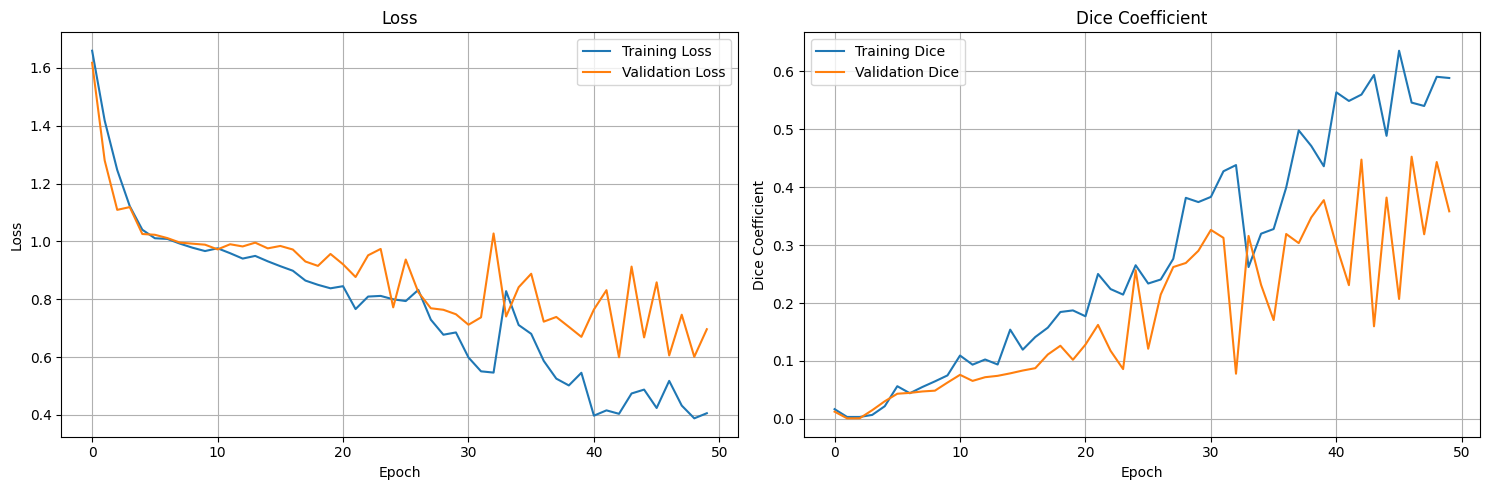

In [ ]:
# Cell 15: Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Dice coefficient
    ax2.plot(history.history['dice_coefficient'], label='Training Dice')
    ax2.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    ax2.set_title('Dice Coefficient')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - binary_accuracy: 0.9896 - dice_coefficient: 0.4331 - loss: 0.6151
Validation Loss: 0.5990
Validation Dice Coefficient: 0.4476
Validation Binary Accuracy: 0.9902
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


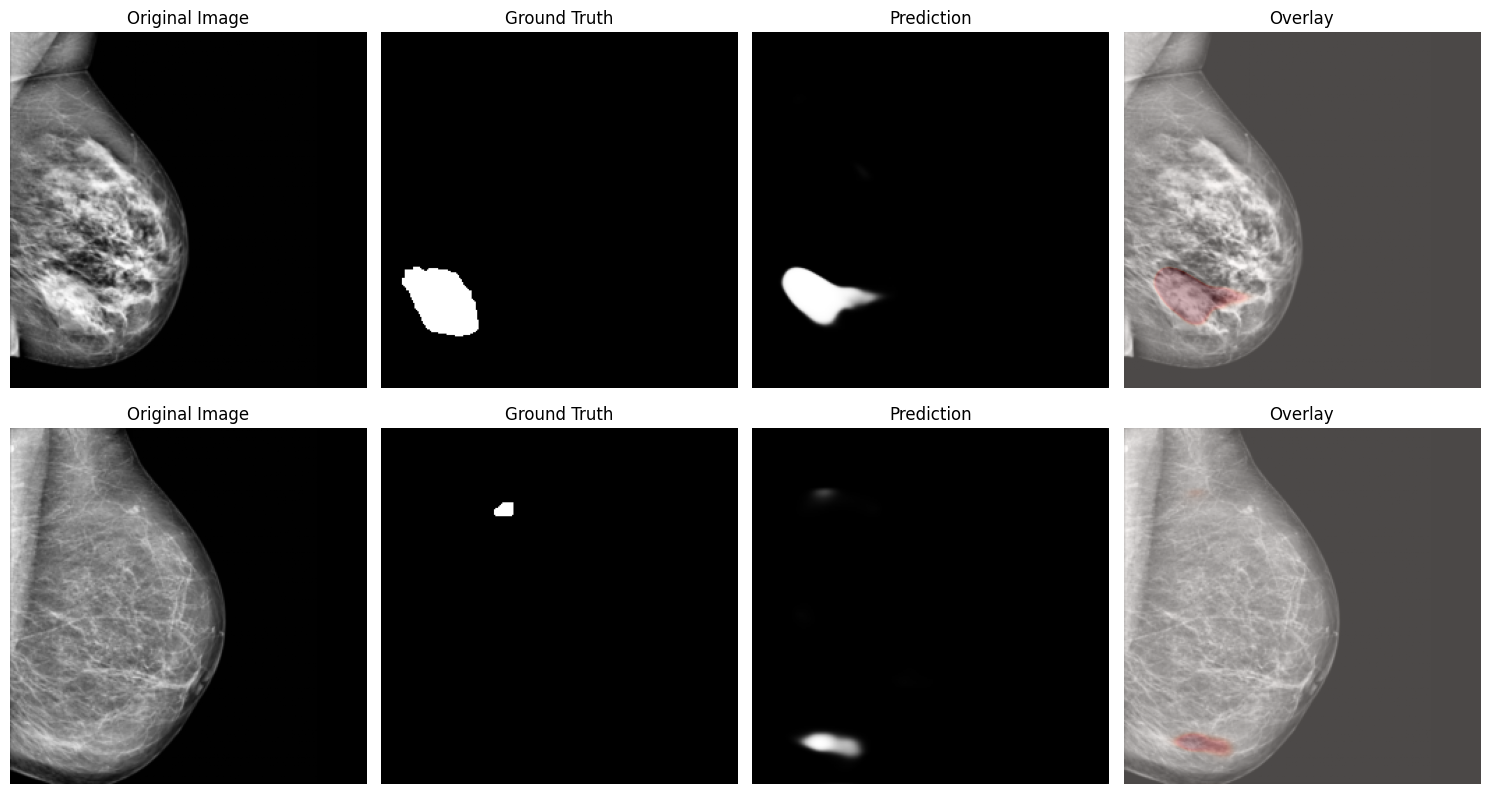

In [ ]:
# Cell 16: Evaluate the model on validation data
val_loss, val_dice, val_accuracy = unet_model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Dice Coefficient: {val_dice:.4f}")
print(f"Validation Binary Accuracy: {val_accuracy:.4f}")

# Cell 17: Generate and visualize predictions
def visualize_predictions(dataset, model, num_samples=5):
    """Visualize model predictions on sample images"""
    plt.figure(figsize=(15, 4*num_samples))

    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        preds = model.predict(images)

        for j in range(min(1, len(images))):  # Just take the first image in the batch
            # Original image
            plt.subplot(num_samples, 4, i*4 + 1)
            plt.imshow(images[j].numpy().squeeze(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            # Ground truth mask
            plt.subplot(num_samples, 4, i*4 + 2)
            plt.imshow(masks[j].numpy().squeeze(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')

            # Predicted mask
            plt.subplot(num_samples, 4, i*4 + 3)
            plt.imshow(preds[j].squeeze(), cmap='gray')
            plt.title('Prediction')
            plt.axis('off')

            # Overlay
            plt.subplot(num_samples, 4, i*4 + 4)
            plt.imshow(images[j].numpy().squeeze(), cmap='gray')
            plt.imshow(preds[j].squeeze(), alpha=0.3, cmap='Reds')
            plt.title('Overlay')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(val_dataset, unet_model)

In [ ]:
# Cell 18: Implement functions to evaluate the model using standard metrics
def evaluate_segmentation(model, dataset):
    """Evaluate segmentation using various metrics"""
    dice_scores = []
    iou_scores = []

    for images, true_masks in dataset:
        pred_masks = model.predict(images)

        for i in range(len(images)):
            # Threshold predictions
            pred = (pred_masks[i].squeeze() > 0.5).astype(np.float32)
            true = true_masks[i].numpy().squeeze()

            # Calculate Dice
            dice = 2 * (np.sum(pred * true)) / (np.sum(pred) + np.sum(true) + 1e-6)
            dice_scores.append(dice)

            # Calculate IoU (Jaccard Index)
            intersection = np.sum(pred * true)
            union = np.sum(pred) + np.sum(true) - intersection
            iou = intersection / (union + 1e-6)
            iou_scores.append(iou)

    print(f"Mean Dice Score: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
    print(f"Mean IoU Score: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")

    return dice_scores, iou_scores

In [ ]:
# Cell 19: Run evaluation
dice_scores, iou_scores = evaluate_segmentation(unet_model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Mean Dice Score: 0.2954 ± 0.3441
Mean IoU Score: 0.2316 ± 0.2914
